In [6]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

In [7]:
class UNetModel(nn.Module):

    def __init__(self,input_channels=3,output_channels=3):
        super().__init__()
        self.layer1 = self.defineFirstLayer(input_channels)
        self.layer2 = self.defineSecondLayer()
        self.layer3 = self.defineThirdLayer()
        self.layer4 = self.defineFourthLayer()
        self.layer5 = self.defineFifthLayer()
        self.upCov1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.layer6 = self.defineSixthLayer()
        self.upCov2 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.layer7 = self.defineSeventhLayer()
        self.upCov3 = nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
        self.layer8 = self.defineEighthLayer()
        self.upCov4 = nn.ConvTranspose2d(16,8,kernel_size=2,stride=2)
        self.layer9 = self.defineNinthLayer(output_channels)
    
    def defineFirstLayer(self,input_channels):
        return nn.Sequential(
            nn.Conv2d(input_channels,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU()
        )
    
    def defineSecondLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(8,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineThirdLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(16,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFourthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFifthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )

    def defineSixthLayer(self):
        return nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    
    def defineSeventhLayer(self):
        return nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineEighthLayer(self):
        return nn.Sequential(
            nn.Conv2d(32,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineNinthLayer(self,output_channels):
        return nn.Sequential(
            nn.Conv2d(16,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,output_channels,kernel_size=1)
        )
    
    def crop_and_cat(self,cropTensor,catTensor,crop_by=(4,4)):
        cropTensor = self.crop(cropTensor,crop_by)
        # print(cropTensor.shape)
        # print(catTensor.shape)
        return torch.cat((cropTensor, catTensor),dim=1)


    def crop(self,cropTensor,crop_by):
        # print(crop_by)
        match crop_by:
            case (16,17):
                return cropTensor[:,:,crop_by[0]:-crop_by[0]-1,crop_by[1]:-crop_by[1]+1] 
            case _:
                return cropTensor[:,:,crop_by[0]:-crop_by[0],crop_by[1]:-crop_by[1]]
    
    def forward(self,X):
        X1 = self.layer1(X)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=(4,4))
        X6 = self.layer6(X5_with_upscale)  
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=(16,17))
        X7 = self.layer7(X6_with_upscale)  
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=(41,41))
        X8 = self.layer8(X7_with_upscale)  
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=(90,90))
        X9 = self.layer9(X8_with_upscale)  
        return X9

model = UNetModel(input_channels=1,output_channels=1)
X = torch.rand(size=(1, 1, 256, 256), dtype=torch.float32)
model(X).shape

torch.Size([1, 1, 68, 68])

In [8]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(50),
        transforms.Resize((256,256))
    ]
)
training_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
validation_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)


train_iter = torch.utils.data.DataLoader(training_data, batch_size=500, shuffle=True)

In [9]:
def train(net, train_iter, num_epochs, lr):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.0001)
  loss = nn.MSELoss(reduction='mean')
  x_resize = torchvision.transforms.Resize((68,68))
  for epoch in range(num_epochs):
    net.train()
    for i, (X,_) in enumerate(train_iter):
      optimizer.zero_grad()
      y_hat = net(X)
      y = x_resize(X)
      l = loss.forward(y_hat,y)
      optimizer.step()
      with torch.no_grad():
        print(f'epoch : {epoch}, batch per epoch : {i}, Y : {l}')

In [10]:
lr, num_epochs = 0.007, 2
train(model, train_iter, num_epochs, lr)

epoch : 0, batch per epoch : 0, Y : 0.15566317737102509
epoch : 0, batch per epoch : 1, Y : 0.15587007999420166
epoch : 0, batch per epoch : 2, Y : 0.15569156408309937
epoch : 0, batch per epoch : 3, Y : 0.1555415689945221
epoch : 0, batch per epoch : 4, Y : 0.155725359916687
epoch : 0, batch per epoch : 5, Y : 0.15586641430854797
epoch : 0, batch per epoch : 6, Y : 0.1557224541902542
epoch : 0, batch per epoch : 7, Y : 0.15570756793022156
epoch : 0, batch per epoch : 8, Y : 0.1557116061449051
epoch : 0, batch per epoch : 9, Y : 0.1558571308851242
epoch : 0, batch per epoch : 10, Y : 0.15564516186714172
epoch : 0, batch per epoch : 11, Y : 0.15581640601158142
epoch : 0, batch per epoch : 12, Y : 0.15559476613998413
epoch : 0, batch per epoch : 13, Y : 0.15564613044261932
epoch : 0, batch per epoch : 14, Y : 0.15566390752792358
epoch : 0, batch per epoch : 15, Y : 0.1557714194059372
epoch : 0, batch per epoch : 16, Y : 0.15585216879844666
epoch : 0, batch per epoch : 17, Y : 0.155644387

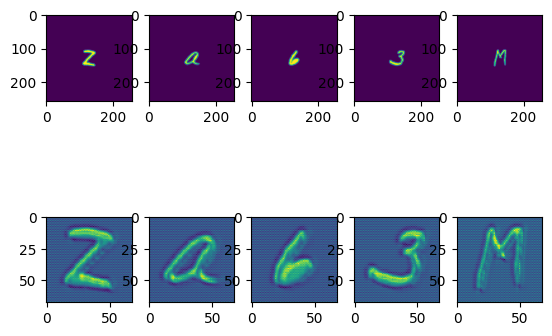

In [20]:
transform = transforms.Compose(
    [
        lambda img: torchvision.transforms.functional.rotate(img, -90),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Pad(50),
        transforms.Resize((256,256))
    ]
)

emnist = torchvision.datasets.EMNIST(root="../data/EMINST", split="byclass", download=True, transform=transform)
i=0
model.eval()
for image,y in emnist:
    x = torch.unsqueeze(image,dim=0)
    # print(x.shape)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1,2,0))
    with torch.no_grad():
        result = model(x)[0]
        plt.subplot(2, 5, i+6)
        plt.imshow(result.permute(1,2,0))
    i+=1
    if i>=5:
        break
    
plt.show()


epoch : 0, batch per epoch : 0, Y : 0.06607279181480408
epoch : 0, batch per epoch : 0, Y : 0.2909037470817566
epoch : 0, batch per epoch : 0, Y : 0.007301113102585077
epoch : 0, batch per epoch : 0, Y : 0.12563873827457428
epoch : 0, batch per epoch : 0, Y : 0.06338629126548767
epoch : 0, batch per epoch : 0, Y : 0.12046880275011063
epoch : 0, batch per epoch : 0, Y : 0.19467803835868835
tensor([0.0868], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.025685882195830345
epoch : 0, batch per epoch : 0, Y : 0.10147272050380707
epoch : 0, batch per epoch : 0, Y : 0.007233690936118364
epoch : 0, batch per epoch : 0, Y : 0.004848667420446873
epoch : 0, batch per epoch : 0, Y : 0.004845011048018932
epoch : 0, batch per epoch : 0, Y : 0.06820975989103317
epoch : 0, batch per epoch : 0, Y : 0.17603585124015808
tensor([0.0388], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.05648422613739967
epoch : 0, batch per epoch : 0, Y : 0.03852042555809021
epoch : 0, batch per epoch : 0, Y : 0.039127983152866364
epoch : 0, batch per epoch : 0, Y : 0.022580832242965698
epoch : 0, batch per epoch : 0, Y : 0.042607951909303665
epoch : 0, batch per epoch : 0, Y : 0.15859293937683105
epoch : 0, batch per epoch : 0, Y : 0.07091289758682251
tensor([0.0429], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.006026414688676596
epoch : 0, batch per epoch : 0, Y : 0.023597370833158493
epoch : 0, batch per epoch : 0, Y : 0.10080236941576004
epoch : 0, batch per epoch : 0, Y : 0.006436562165617943
epoch : 0, batch per epoch : 0, Y : 0.04143254831433296
epoch : 0, batch per epoch : 0, Y : 0.006315445527434349
epoch : 0, batch per epoch : 0, Y : 0.01111914124339819
tensor([0.0196], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.005299033131450415
epoch : 0, batch per epoch : 0, Y : 0.040548600256443024
epoch : 0, batch per epoch : 0, Y : 0.16336983442306519
epoch : 0, batch per epoch : 0, Y : 0.01756376214325428
epoch : 0, batch per epoch : 0, Y : 0.009459301829338074
epoch : 0, batch per epoch : 0, Y : 0.00499036256223917
epoch : 0, batch per epoch : 0, Y : 0.19635295867919922
tensor([0.0438], grad_fn=<DivBackward0>)

epoch : 0, batch per epoch : 0, Y : 0.02695949748158455
epoch : 0, batch per epoch : 0, Y : 0.012122327461838722
epoch : 0, batch per epoch : 0, Y : 0.132175013422966
epoch : 0, batch per epoch : 0, Y : 0.13024772703647614
epoch : 0, batch per epoch : 0, Y : 0.020091138780117035
epoch : 0, batch per epoch : 0, Y : 0.05679721385240555
epoch : 0, batch per epoch : 0, Y : 0.07385918498039246
tensor([0.0452], grad_fn=<DivBackward0>)

